# Yarkoni 2010 Analysis

In [1]:
import collections
import itertools
import logging
import os.path
import pickle
import warnings

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

logging.basicConfig(level=logging.INFO, format="[%(levelname)s] %(name)s: %(message)s")

import data

/mnt/c/Users/koerner/Desktop/robert-power-and-language-files-osf/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prepare data

In [33]:
fn_study_prepared = "studydata.pickle"

if not os.path.exists(fn_study_prepared):
    df_study1, df_study2 = data.prepare_study_data()

    with open(fn_study_prepared, "wb") as fp:
        pickle.dump(df_study1, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(df_study2, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open(fn_study_prepared, "rb") as fp:
    df_study1 = pickle.load(fp)
    df_study2 = pickle.load(fp)

df_study1, df_study2 = data.clean_study_data(df_study1, df_study2, do_clean_stopwords=False)

[INFO] data: Clean study data ...


> To investigate the relation between personality and language use at the level of individual words, two sets of analyses were conducted. First, to identify the strongest word-level correlates of each personality trait, I correlated bloggers' personality scores with a set of 5,068 individual words.

> #### Word-based analyses

> To produce a normalized measure of word use that could be meaningfully compared across blogs, I divided the number of times each word occurred in a given blog by the total number of word tokens used in that blog. All words were stripped of any leading or trailing punctuation prior to analysis. Although many of the LIWC categories include all words that share a particular stem, words were left unstemmed in the present study because preliminary analysis indicated that many words with the same stem had quite different patterns of correlation with personality (e.g., “love” and “lover”).

> Because the vast majority of English words have a frequency of less than 1 in 10,000 words, two steps were adopted in order to increase the reliability of the single-word measures. First, only the 5,608 words that occurred most frequently across all blogs were analyzed; second, only blogs containing 50,000 or more words were included in the word-level analyses (N = 406).

> To ensure that these cut-offs were sufficient for reliable estimation of word use, a splithalf reliability analysis was conducted (i.e., all posts within each blog were randomly assigned to one of two halves, and the correlation between halves was then computed across all blogs). Figure 1 displays loess-smoothed split-half correlations for the 5,000 most frequent words as a function of word rank. The analysis suggested that reliability was high to moderate (> .6) for the first 2,000 – 3,000 or so words, and somewhat lower thereafter. However, even for lowranked words, split-half correlations generally remained above .4, a level considered acceptable for present purposes given that word-level analyses focused primarily on the aggregate pattern of associations with personality rather than individual correlations. Word-level results were thresholded at p < .001 in order to minimize the incidence of false positives.

In [34]:
print(f"Number of documents: {len(df_study1)}")

df_scores = df_study1[["power", "prestige", "dominance", "power_f", "prestige_f", "dominance_f"]]


# preprocessed documents (spacy tokenized, some filtering of non-words)
df_documents = df_study1["text_spacy_doc_filtered"]

# NOTE: (do) we want to keep the stopwords?
#df_documents = df_study1["text_spacy_doc"]
#df_documents = data.clean(df_documents, stopwords=False, alpha=True, punctuation=True)


# get plain list of tokens per document (no lemmatizing)
df_tokens = data.get_tokens_by_pos(df_documents, pos_list=None, lemma=False, join=False)
#df_scores["tokens"] = df_tokens


Number of documents: 200


In [35]:
# count number of tokens
def _count_tokens_fn(doc):
    num_tokens = len(doc)
    cnt = collections.Counter(doc)
    return {word: num / num_tokens for word, num in cnt.items()}

df_tokens_weighted = df_tokens.map(_count_tokens_fn)


# get N-most frequently occuring words (based on relative counts)
types = collections.Counter()
for doc in df_tokens_weighted.values.tolist():
    types.update(doc)

print(f"Number of types (unique word forms): {len(types)}")
print()

# set cutoff
N = len(types)
N = 1000

types_top_N = types.most_common(N)
print(f"Top-10 Types: {', '.join('{} ({:.2f})'.format(w, c) for w, c in types_top_N[:10])}")
print(f"Bottom-10 Types: {', '.join('{} ({:.2f})'.format(w, c) for w, c in types_top_N[-10:])}")
types_top_N = dict(types_top_N)


# filter out types in documents that are not in top-N
types_to_keep = set(types_top_N.keys())
def _filter_tokens_fn(doc):
    return {k: v for k, v in doc.items() if k in types_to_keep}

df_tokens_weighted_filtered = df_tokens_weighted.map(_filter_tokens_fn)

Number of types (unique word forms): 2529

Top-10 Types: Ich (11.33), und (11.22), bin (8.79), ich (5.26), mich (3.14), sehr (3.07), zu (2.76), ein (2.46), in (2.12), mit (2.03)
Bottom-10 Types: schätze (0.03), Dorf (0.03), Andererseits (0.03), Tage (0.03), bleiben (0.03), besuchen (0.03), erwachsene (0.03), durchsetzungsstark (0.03), Kompromisse (0.03), eingehe (0.03)


In [36]:
# get updated token weights --> since total token count changed, recompute
def _count_tokens_filtered_fn(doc):
    cnt = collections.Counter(doc)
    cnt = {k: v for k, v in cnt.items() if k in types_to_keep}
    num_tokens = sum(cnt.values())
    return {word: num / num_tokens for word, num in cnt.items()}

df_tokens_weighted_filtered = df_tokens.map(_count_tokens_filtered_fn)

types = collections.Counter()
for doc in df_tokens_weighted_filtered.values.tolist():
    types.update(doc)

types_top_N = types.most_common(N)
print(f"Top-10 Types: {', '.join('{} ({:.2f})'.format(w, c) for w, c in types_top_N[:10])}")
print(f"Bottom-10 Types: {', '.join('{} ({:.2f})'.format(w, c) for w, c in types_top_N[-10:])}")
types_top_N = dict(types_top_N)

Top-10 Types: und (12.99), Ich (12.69), bin (9.91), ich (6.33), mich (3.65), sehr (3.47), zu (3.29), ein (2.79), in (2.50), mit (2.43)
Bottom-10 Types: Golf (0.03), Lethargie (0.03), belastet (0.03), zuweilen (0.03), Serien (0.03), laufe (0.03), umsetzen (0.03), übergewichtig (0.03), gespaltenes (0.03), Körper (0.03)


In [37]:
# compute word rank and than split-half-correlation
random_state = 42  # for reproducibility
idx_shuffled = shuffle(df_tokens_weighted_filtered.index.values, random_state=random_state)
half_1, half_2 = idx_shuffled[:len(idx_shuffled) // 2], idx_shuffled[len(idx_shuffled) // 2:]
df_tok_1, df_tok_2 = df_tokens_weighted_filtered[half_1], df_tokens_weighted_filtered[half_2]

def _get_ranks(df_doc):
    types = collections.Counter()
    for doc in df_doc.values.tolist():
        types.update(doc)
    ordered = types.most_common()
    return {word: rank for rank, (word, _) in enumerate(ordered, 1)}

ranks_1, ranks_2 = _get_ranks(df_tok_1), _get_ranks(df_tok_2)
print("Ranks (half/1): ", ", ".join(w for w, _ in list(ranks_1.items())[:10]))
print("Ranks (half/2): ", ", ".join(w for w, _ in list(ranks_2.items())[:10]))
print()

ranklist_1 = np.array([ranks_1.get(word, None) for word in types_top_N.keys()], dtype=np.float)
ranklist_2 = np.array([ranks_2.get(word, None) for word in types_top_N.keys()], dtype=np.float)
# pd.DataFrame([types_all, ranklist_1, ranklist_2]).T.rename(columns={1: "words", 1: "half-1", 2: "half-2"})

res = scipy.stats.spearmanr(ranklist_1, ranklist_2, nan_policy="omit", alternative="greater")
print(res)
print()

for cutoff in (10, 20, 50, 100, 200, 500, 750, 1000):
    ranklist_1_sub, ranklist_2_sub = ranklist_1[:cutoff], ranklist_2[:cutoff]

    res = scipy.stats.spearmanr(ranklist_1_sub, ranklist_2_sub, nan_policy="omit")
    print(f"top-{cutoff}: {res.correlation=}")


Ranks (half/1):  und, Ich, bin, ich, zu, sehr, mich, in, ein, mit
Ranks (half/2):  Ich, und, bin, ich, mich, sehr, ein, zu, mit, die

SpearmanrResult(correlation=0.5622895940938863, pvalue=8.591768161160716e-50)

top-10: res.correlation=0.8545454545454544
top-20: res.correlation=0.9233082706766916
top-50: res.correlation=0.8915726290516206
top-100: res.correlation=0.7727572757275726
top-200: res.correlation=0.610360895386021
top-500: res.correlation=0.5065665496022397
top-750: res.correlation=0.5388024276906572
top-1000: res.correlation=0.5622895940938863


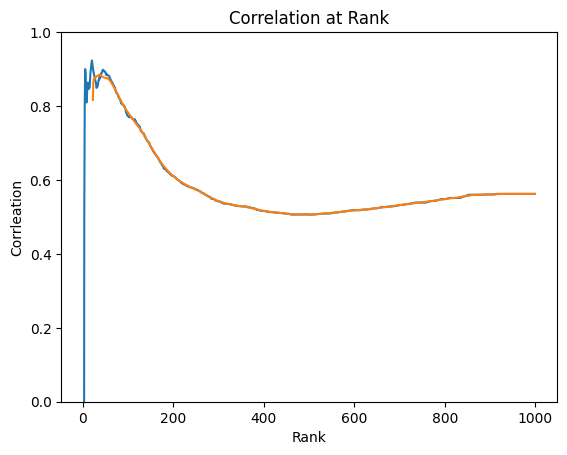

In [38]:
ranks = np.arange(1, N)
corrs = np.array([scipy.stats.spearmanr(ranklist_1[:cutoff], ranklist_2[:cutoff], nan_policy="omit").correlation for cutoff in ranks])

# https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way
# https://stackoverflow.com/questions/11352047/finding-moving-average-from-data-points-in-python/34387987#34387987

from scipy.signal import savgol_filter
corrshat = savgol_filter(corrs, 41, 1) # window size 51, polynomial order 1

# def smooth(y, box_pts):
#     box = np.ones(box_pts)/box_pts
#     y_smooth = np.convolve(y, box, mode='same')
#     return y_smooth
# corrshat = smooth(corrs, 51)

# import statsmodels as sm
# import statsmodels.nonparametric.smoothers_lowess
# win = 31
# corrshat = sm.nonparametric.smoothers_lowess.lowess(corrs, ranks, frac=(5*win / len(corrs)), return_sorted=False)

plt.plot(ranks, corrs)
plt.plot(ranks, corrshat)
plt.title("Correlation at Rank")
plt.ylabel("Corrleation")
plt.xlabel("Rank")
plt.ylim((0, 1))
plt.show()

In [ ]:
# ?

start = 500
ende = 750
ranks = np.arange(start + 10, ende)
corrs = np.array([scipy.stats.spearmanr(ranklist_1[start:cutoff], ranklist_2[start:cutoff], nan_policy="omit").correlation for cutoff in ranks])

# https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way
# https://stackoverflow.com/questions/11352047/finding-moving-average-from-data-points-in-python/34387987#34387987

from scipy.signal import savgol_filter
corrshat = savgol_filter(corrs, 41, 1) # window size 51, polynomial order 1

plt.plot(ranks, corrs)
plt.plot(ranks, corrshat)
plt.title("Correlation at Rank")
plt.ylabel("Corrleation")
plt.xlabel("Rank")
#plt.ylim((0, 1))
plt.show()